# Imports

In [1]:
#!pip install obonet  numpy pandas matplotlib  sklearn python-bidi arabic_reshaper 
#!wget http://purl.obolibrary.org/obo/go.obo
import pandas
import numpy
import requests,math,pickle
import networkx,obonet
import numpy as np ,pandas as pd, matplotlib.pyplot as plt
import arabic_reshaper
import multiprocessing as mp
import scipy.stats as stats
from sklearn.metrics.cluster import *
from bidi.algorithm import get_display
from functools import partial
import sys
import gc
from IPython.display import clear_output
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

def fa(text):
    return get_display(arabic_reshaper.reshape(u'%s' % str(text)))

## Multi server parallel computing

In [4]:
import ipyparallel as ipp
!./runAndCpToEngine.sh
clear_output()
c = ipp.Client()
print(c.ids)
dview = c[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [12]:
%%px
import mpi4py
from mpi4py import MPI
from ipykernel.datapub import publish_data

world = MPI.COMM_WORLD
world_group = world.Get_group()
group = world_group.Incl(range(0, 10))
my_root = group.Translate_ranks(group, [0], world_group)[0]
comm = world.Create(group)

In [15]:
%%px
# MPI initialization, library imports and sanity checks on all engines
from mpi4py import MPI
# Load data publication API so engines can send data to notebook client
from ipykernel.datapub import publish_data
import numpy as np
import time

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
size = mpi.size
print("MPI rank: %i/%i" % (mpi.rank,mpi.size))

[stdout:0] MPI rank: 2/10
[stdout:1] MPI rank: 0/10
[stdout:2] MPI rank: 6/10
[stdout:3] MPI rank: 4/10
[stdout:4] MPI rank: 1/10
[stdout:5] MPI rank: 3/10
[stdout:6] MPI rank: 8/10
[stdout:7] MPI rank: 5/10
[stdout:8] MPI rank: 9/10
[stdout:9] MPI rank: 7/10


[stderr:0] 
<ipython-input-9-d927632362d1>:4: DeprecationWarning: ipykernel.datapub is deprecated. It has moved to ipyparallel.datapub
  from ipykernel.datapub import publish_data
[stderr:1] 
<ipython-input-9-d927632362d1>:4: DeprecationWarning: ipykernel.datapub is deprecated. It has moved to ipyparallel.datapub
  from ipykernel.datapub import publish_data
[stderr:2] 
<ipython-input-9-d927632362d1>:4: DeprecationWarning: ipykernel.datapub is deprecated. It has moved to ipyparallel.datapub
  from ipykernel.datapub import publish_data
[stderr:3] 
<ipython-input-9-d927632362d1>:4: DeprecationWarning: ipykernel.datapub is deprecated. It has moved to ipyparallel.datapub
  from ipykernel.datapub import publish_data
[stderr:4] 
<ipython-input-9-d927632362d1>:4: DeprecationWarning: ipykernel.datapub is deprecated. It has moved to ipyparallel.datapub
  from ipykernel.datapub import publish_data
[stderr:5] 
<ipython-input-9-d927632362d1>:4: DeprecationWarning: ipykernel.datapub is deprecated. I

In [16]:
dview['rank']

[2, 0, 6, 4, 1, 3, 8, 5, 9, 7]

In [5]:
with dview.sync_imports():
    import pandas
    import numpy

importing pandas on engine(s)
importing numpy on engine(s)


In [6]:
dataset_name = "CAMI_Low"
num_cores = max(mp.cpu_count() - 3, 1)
!mkdir -p ./Output/{dataset_name}/figs
!mkdir -p ./Temp/{dataset_name}/

In [7]:
def to_biobox(df, path):
    df[df["bin_id"]!= 0].to_csv(path, index=None, sep='\t',header=None)    
    with open(path, 'r') as file:        
        text = file.read()
    with open(path, 'w', encoding='utf8') as file:
        file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

# Read Fasta

In [8]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    ids = []
    contigs = []
    for l in lines:
        if(l[0]=='>'):
            ids.append(l)        
            contigs.append(s)
            s = ''
        else:
            s += l    
    contigs.append(s)
    df = pd.DataFrame(
            {
                '#anonymous_gsa_id': ids,
                'contig': contigs[1:]
            })
    df['#anonymous_gsa_id'] = df['#anonymous_gsa_id'].apply(lambda x: x[1:])    
    return df

In [9]:
contigs = fasta_to_df(f"./Dataset/{dataset_name}/contigs.fna")
all_number = contigs.shape[0]
contigs["contig_length"] = contigs["contig"].apply(lambda x: len(x))
del contigs['contig']
contigs.head(2)

,#anonymous_gsa_id,contig_length
0,RL|S1|C0,809
1,RL|S1|C1,626


In [10]:
df = pd.read_csv(f"./Dataset/{dataset_name}/mapping.tsv", sep='\t')
contigs = pd.merge(contigs, df, how='inner', on='#anonymous_gsa_id')
del contigs['sequence_id']
contigs.head(2)

,#anonymous_gsa_id,contig_length,bin_id,tax_id,number_reads
0,RL|S1|C0,809,1220_AJ,75309,12
1,RL|S1|C1,626,1048993,328515,16


# Save gold standard data as CAMI binning Bioboxes format.

In [11]:
path = f"./Temp/{dataset_name}/gold_standard"
contigs[['#anonymous_gsa_id', 'bin_id', 'tax_id',
         'contig_length']].to_csv(path, index=None, sep='\t')

with open(path, 'r') as file:
    file.readline()
    text = file.read()

with open(path, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\tTAXID\t_LENGTH\n"+ text)

# Base Algorithms

In [12]:
def get_base_bin(bin_name, prob=0):
    try:
        df = pd.read_csv(f"./Binning/{dataset_name}/{bin_name}/prob{prob}/contigs.tab", sep='\t', header = None)
        df.columns = ['#anonymous_gsa_id','bin_id']
        df = df[df["bin_id"]!= 0]
        to_biobox(df, f"./Temp/{dataset_name}/{bin_name}_p{prob}")
        print(f'binned contigs: {df.shape[0]}', f'{round(df.shape[0]*100 / all_number,2)}% assigned')    
        display(df.head(2))
        return df
    except:
        print("error happend")
        return None

## busybee

In [13]:
busybee_p0 = get_base_bin('Busybee',0)

binned contigs: 12857 65.94% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C0,1
1,RL|S1|C1,5


In [14]:
busybee_p20 = get_base_bin('Busybee',20)

binned contigs: 12514 64.18% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C0,1
1,RL|S1|C1,5


In [15]:
busybee_p50 = get_base_bin('Busybee',50)

binned contigs: 8662 44.42% assigned


,#anonymous_gsa_id,bin_id
2,RL|S1|C2,3
3,RL|S1|C3,1


## metabat 1

In [16]:
metabat1_p30 = get_base_bin('Metabat1',30)

binned contigs: 5986 30.7% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19179,1
1,RL|S1|C19147,1


In [17]:
metabat1_p50 = get_base_bin('Metabat1',50)

binned contigs: 5710 29.28% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19179,1
1,RL|S1|C19147,1


In [18]:
metabat1_p70 = get_base_bin('Metabat1',70)

binned contigs: 5815 29.82% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19179,1
1,RL|S1|C19147,1


In [19]:
metabat1_p80 = get_base_bin('Metabat1',80)

binned contigs: 5673 29.09% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19147,1
1,RL|S1|C19085,1


In [20]:
metabat1_p90 = get_base_bin('Metabat1',90)

binned contigs: 5322 27.29% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19446,1
1,RL|S1|C19333,1


In [21]:
metabat1_p95 = get_base_bin('Metabat1',95)

binned contigs: 5021 25.75% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C19446,1
1,RL|S1|C19333,1


## metabat2

In [22]:
metabat2_p50 = get_base_bin('Metabat2',50)

binned contigs: 3869 19.84% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C9238,1
1,RL|S1|C15230,1


In [23]:
metabat2_p80 = get_base_bin('Metabat2',80)

error happend


In [24]:
metabat2_p95 = get_base_bin('Metabat2',95)

binned contigs: 1687 8.65% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C6180,1
1,RL|S1|C7437,1


## maxbin2

In [25]:
maxbin2_p50 = get_base_bin('Maxbin2',50)

binned contigs: 7999 41.02% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C135,7
1,RL|S1|C465,7


In [26]:
maxbin2_p80 = get_base_bin('Maxbin2',80)

binned contigs: 7567 38.81% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C135,7
1,RL|S1|C465,7


In [27]:
maxbin2_p90 = get_base_bin('Maxbin2',90)

binned contigs: 7498 38.45% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C135,7
1,RL|S1|C465,7


In [28]:
maxbin2_p95 = get_base_bin('Maxbin2',95)

binned contigs: 7227 37.06% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C465,7
1,RL|S1|C618,7


## Assesment

In [ ]:
!amber.py -g ./Temp/{dataset_name}/gold_standard \
-o ./Output/{dataset_name}/Assesment \
./Temp/{dataset_name}/maxbin2_p50 \
./Temp/{dataset_name}/maxbin2_p80 \
./Temp/{dataset_name}/maxbin2_p90 \
./Temp/{dataset_name}/maxbin2_p95 

'''./Temp/{dataset_name}/busybee_p0 \
./Temp/{dataset_name}/busybee_p20 \
./Temp/{dataset_name}/busybee_p50 \
./Temp/{dataset_name}/metabat1_p30 \
./Temp/{dataset_name}/metabat1_p50 \
./Temp/{dataset_name}/metabat1_p70 \
./Temp/{dataset_name}/metabat1_p80 \
./Temp/{dataset_name}/metabat1_p90 \
./Temp/{dataset_name}/metabat1_p95 \
./Temp/{dataset_name}/metabat2_p50 \
./Temp/{dataset_name}/metabat2_p95 \ ''';

# Gene Ontology
## https://www.ebi.ac.uk/QuickGO/api/index.html#/gene_ontology

In [29]:
go = pd.read_csv(f"./Annotation/{dataset_name}/cds.gene2go.tab.txt", sep='\t')
go = go.reset_index(drop=True)
go = go[['#Gene','Contig','TM']]
go.head(2)

,#Gene,Contig,TM
0,RL|S1|C13963,1160,GO:0016811
1,RL|S1|C13963,1160,GO:0019740


## Add namespace [ cc, bp, mf ]

In [30]:
go_graph = obonet.read_obo('./go.obo') 
accession_to_namespace = dict()
go_ids = go['TM'].unique()
for accession in go_ids:
    try:        
        accession_to_namespace[accession] =  go_graph.nodes[accession]['namespace']
    except: 
        # if not exist,store in list to get from API                        
        r = requests.get("https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/" + accession
                     , headers={ "Accept" : "application/json"})
        if not r.ok:
            print(f'Not found ', r.raise_for_status())                                              
        else:
            accession_to_namespace[accession]= r.json()['results'][0]['aspect']         

In [31]:
def get_namespace(accession):
    if(accession in accession_to_namespace):        
        return accession_to_namespace[accession]    
    return "unknown"

go['Namespace'] = go['TM'].apply(lambda x : get_namespace(x) )
print(go['Namespace'].value_counts())
go.head(2)

molecular_function    196928
biological_process    138153
cellular_component     79222
Name: Namespace, dtype: int64


,#Gene,Contig,TM,Namespace
0,RL|S1|C13963,1160,GO:0016811,molecular_function
1,RL|S1|C13963,1160,GO:0019740,biological_process


# Improver Method

## Create dictionary BP, CC , MF base of GOGO for each pair of go ids

In [151]:
def runGOGO(i,namespace):        
    %cd ./GOGO/
    !perl go_comb.pl ../Temp/{dataset_name}/{namespace}/go_ids{i}.txt ../Temp/{dataset_name}/{namespace}/go_ids_scores{i}
    %cd ..    

In [152]:
def Step1(namespace):    
    !rm -r ./Temp/{dataset_name}/{namespace}/ 
    !mkdir ./Temp/{dataset_name}/{namespace}/
    # first create all possible pairs of GOs for Biological Process
    go_ids = go[go["Namespace"] == namespace]['TM'].unique()    
    go1 = []
    go2 = []
    for i in range(0,go_ids.shape[0]):
        for j in range(i, go_ids.shape[0]):            
            go1.append(go_ids[i])
            go2.append(go_ids[j])
    df = pd.DataFrame({'goid1': go1,'goid2': go2},columns = ['goid1', 'goid2'])
    indexes = np.linspace(0,df.shape[0], num_cores + 1) // 1
    indexes[-1] =  df.shape[0]
    
    for i in range(0, num_cores):
        dfi = df.iloc[int(indexes[i]):int(indexes[i+1]),:]
        dfi.to_csv(f"./Temp/{dataset_name}/{namespace}/go_ids{i}.txt",sep=" ",index=None,header=None)
        
    # now run GOGO in multiprocessing
    if __name__ == '__main__':        
        pool = mp.Pool(num_cores)        
        pool.map(partial(runGOGO, namespace=namespace), range(0,num_cores))      
        
    clear_output()

In [153]:
def Step2(namespace):            
    def add2dict(row, dictionary):
        dictionary[row[0]+row[1]] = row[3]
        dictionary[row[1]+row[0]] = row[3]
    print('start reading files')            
    lines = []
    for i in range(0,num_cores):
        with open(f"./Temp/{dataset_name}/{namespace}/go_ids_scores{i}","r") as f:
            text = f.read()
            lines = [*lines, *[l for l in text.split("\n") if len(l) > 0 and l[-24:] != "not_in_the_same_ontology"]]                        
    print('files reading process was finished.')        
    print('start adding to dictionary')        
    df = pd.read_csv(StringIO('\n'.join(lines)), sep=" ", header=None)                
    dictionary = dict()    
    df.apply(lambda row:add2dict(row, dictionary), axis=1)
    print('adding to dictionary was finished')                   
    with open(f"./Temp/{dataset_name}/{namespace}.pkl", "wb") as file:
        pickle.dump(dictionary, file)        
    !rm -r ./Temp/{dataset_name}/{namespace}/    

### biological process

In [154]:
Step1("biological_process")

rm: cannot remove './Temp/CAMI_Low/biological_process/': No such file or directory
/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO/home/jupyter/Final/GOGO

In [155]:
Step2("biological_process")

### cellular component

In [156]:
Step1("cellular_component")

In [157]:
Step2("cellular_component")

### molecular function

In [158]:
Step1("molecular_function")

In [159]:
Step2("molecular_function")

## Load data

In [32]:
def standard_normalized(data):
    data = np.array(sorted(data,reverse=True))
    data = (data - data.mean() ) / data.std()
    data -= data.min()
    data /= data.max()
    return data

In [33]:
base = metabat2_p95
unlabelled = contigs[~contigs['#anonymous_gsa_id'].isin(base['#anonymous_gsa_id'])]
print(unlabelled.shape)
unlabelled = unlabelled[unlabelled['contig_length']>=1000]
print(unlabelled.shape)

(17812, 5)
(6754, 5)


In [34]:
number_of_bins = base['bin_id'].max() 
print(number_of_bins)

bins = [0 for i in range(0,number_of_bins)]
for i in range(0, number_of_bins):    
    bins[i] = pd.merge(go, base[base['bin_id']==(i+1)], how="inner", 
                    left_on='#Gene',right_on="#anonymous_gsa_id")    

84


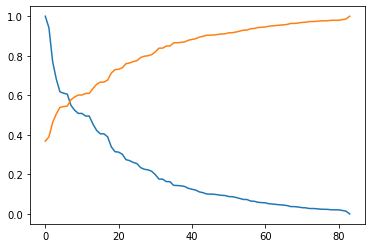

In [35]:
bins_portion = [0 for i in range(0,number_of_bins)]    
for i in range(0, number_of_bins):    
    bins_portion[i] = bins[i].shape[0]
    
bins_portion = standard_normalized(bins_portion)
plt.plot(bins_portion)
plt.plot([math.exp(-i) for i in bins_portion])
plt.show()

In [36]:
bins_portion = [0 for i in range(0,number_of_bins)]    
for i in range(0, number_of_bins):    
    bins_portion[i] = bins[i].shape[0]
    
x = np.array(bins_portion)
x = (x - x.mean() ) / x.std()
x -= x.min()
x /= x.max()
bins_portion = [math.exp(-i) for i in x]

In [37]:
for i in range(0, number_of_bins):    
    bins[i] = pd.Series(bins[i]['TM'].unique())    

In [38]:
go_rare = go.groupby("TM")["TM"].count()
go_rare = (go_rare - go_rare.mean()) / go_rare.std()
go_rare = go_rare - go_rare.min()
go_rare = go_rare / go_rare.max()
go_rare = go_rare.apply(lambda x : math.exp(-x))

In [39]:
with open(f"./Temp/{dataset_name}/biological_process.pkl", "rb") as file:
    bp_dictionary = pickle.load(file)

with open(f"./Temp/{dataset_name}/cellular_component.pkl", "rb") as file:
    cc_dictionary = pickle.load(file)
    
with open(f"./Temp/{dataset_name}/molecular_function.pkl", "rb") as file:
    mf_dictionary = pickle.load(file)

In [40]:
'''source = []
target = []
weigth = []
TM = df['TM'].to_numpy()
Go_id = df['go_id'].to_numpy()

for i in range(0, len(TM)-1):
    for j in range(i+1, len(TM)):                
        if(TM[i] + TM[j] in bp_dictionary):
                if(bp_dictionary[TM[i] + TM[j]] > 0.7):
                    source.append(Go_id[i])
                    target.append(Go_id[j])
                    weigth.append(bp_dictionary[ TM[i] + TM[j]])            
df = pd.DataFrame({'source': source, 'target': target, 'weigth': weigth})
df.to_csv('./data.csv', index=None)''';

## Disjoint

### 16S

In [41]:
'''
with open("Annotation/Toy_Low/data/16SrRNA.ffn", "r") as file:    
    lines = [t for t in file.read().split('\n') if len(t) > 0]
    lines = [t for t in lines if t[0] == '>']
    rRNA16S = pd.read_csv(StringIO('\n'.join(lines)), sep="/", header=None)                
    rRNA16S = rRNA16S.iloc[:,1:]
    rRNA16S.columns = ["Name", "rRNA_taxon", "cid"]
    rRNA16S["Name"] = rRNA16S["Name"].apply(lambda x : x.replace("Name=",""))
    rRNA16S["rRNA_taxon"] = rRNA16S["rRNA_taxon"].apply(lambda x : x.replace("rRNA_taxon=",""))
    rRNA16S["cid"] = rRNA16S["cid"].apply(lambda x : x.replace("cid=",""))
print(rRNA16S.shape)
rRNA16S.head()

bins = [[] for i in range(0,number_of_bins+1)]
for i in range(1, number_of_bins+1):
    df = contigs[contigs['Busybee_bin50Percent']==i]
    df = pd.merge(df, rRNA16S, how="inner", left_on="#anonymous_gsa_id", right_on="cid")    
    for index, row in df.iterrows():
        bins[i].append(row['rRNA_taxon'])    
    bins[i] = [s for s in set(bins[i])]    
    
[i for i in range(1, number_of_bins+1) if len(bins[i]) > 1]''';

## Main loop

In [42]:
def getDictionary(namespace):
    if(namespace == "biological_process"):
        return bp_dictionary
    if(namespace == "cellular_component"):
        return cc_dictionary    
    if(namespace == "molecular_function"):
        return mf_dictionary
    
# this function recived a contig and return pred bin and score
def binScore(inp_bin, go_id, dictionary,portion):        
    go_id_rare = go_rare[go_id]
    def run(g):
        pair = g +  go_id                
        if(pair in dictionary):                                          
            return  dictionary[pair] #* portion * go_rare[g] * go_id_rare         
        return 0                
    scores = inp_bin.apply(lambda g: run(g))            
    #scores = scores[scores >= 0]            
    if(scores.shape[0] == 0):
        return 0
    st = sorted(scores,reverse=True)[:number]    
    return sum(st) / len(st)

def getScore(go_id):            
    result = numpy.zeros(number_of_bins)    
    namespace = accession_to_namespace[go_id]    
    for i in range(0,number_of_bins):
        result[i] = binScore(bins[i], go_id, getDictionary(namespace),bins_portion[i])    
    return go_id, result

In [43]:
#pool = mp.Pool(num_cores)    
go_ids = pd.merge(unlabelled, go, how='inner',
             left_on='#anonymous_gsa_id',right_on='#Gene')['TM'].unique()

In [44]:
dview.scatter('go_ids',go_ids)

<AsyncResult: scatter>

In [46]:
dview = c[:3]

In [49]:
dview.activate()

In [50]:
if __name__ == '__main__':
    number = 500        
    #dview
    dview.push(dict(number=number,
                    number_of_bins=number_of_bins,
                    accession_to_namespace=accession_to_namespace,
                    binScore=binScore,
                    bins=bins,
                    getDictionary=getDictionary,
                    bins_portion=bins_portion,
                    bp_dictionary=bp_dictionary))
 #   go_dictionary = dict()   
    #for go_id, result in pool.map(getScore, go_ids):        
#    for go_id, result in dview.map_sync(getScore, go_ids):
#        go_dictionary[go_id] = result

## Pred

In [380]:
alpha = 1  # BP
beta  = 1  # CC
gamma = 1  # MF

def getCoefficient(namespace):
        if(namespace == "biological_process"):
            return alpha
        if(namespace == "cellular_component"):
            return beta    
        if(namespace == "molecular_function"):
            return gamma    
    
def pred(cnt):                                
    coeff = 0
    selected = go[go['#Gene'] == cnt]
    go_ids = selected['TM']                
    go_namespace = selected['Namespace']                
    result = np.zeros((go_ids.shape[0], number_of_bins))    
    for i in range(0,len(go_ids.index)):  
        index = go_ids.index[i]               
        namespace = go_namespace[index]        
        coeff += getCoefficient(namespace)                                         
        result[i,:] = go_dictionary[go_ids[index]] * getCoefficient(namespace)                     
    score = sum(result) / coeff if coeff != 0 else sum(result) * 0            
    index = np.where(score == max(score))[0][0] + 1                
    return index, max(score), cnt    

if __name__ == '__main__':
    answer = {}        
    pool = mp.Pool(num_cores)    
    unlabelledContigs = pd.Series(list(set(unlabelled['#anonymous_gsa_id']).intersection(set(go['#Gene']))))            
    for index, score, cnt in pool.map(pred,unlabelledContigs):        
        answer[cnt] = (index,  score)

{65, 22, 1}


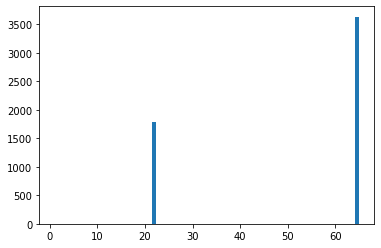

In [381]:
x = [v[0] for v in answer.values()]
plt.hist(x, bins=number_of_bins)
print(set(x))

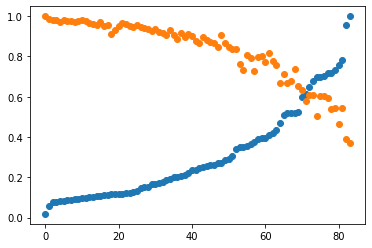

In [368]:
l = []
for i in range(len(bins)):
    l.append(len(bins[i]))

bin_size = np.array(l)/max(np.array(l))    
index = np.argsort(bin_size)
plt.plot([bin_size[i] for i in index],'o')
plt.plot([bins_portion[i] for i in index],'o')

In [377]:
threshold = sorted([i[1] for i in answer.values()], reverse=True)[3000]
print(threshold)
threshold = 0.15
counter = 0
def assign(row):
    global counter
    cnt = row['#anonymous_gsa_id']
    if(cnt in answer and answer[cnt][1] >= threshold):                
        counter += 1
        return answer[cnt][0]    
    return 0

unlabelled['pred'] = unlabelled.apply(lambda row:assign(row),axis=1)    
print(counter)

0.1275888000000001
2262


In [378]:
df = unlabelled[unlabelled['pred']!=0][['#anonymous_gsa_id','pred']]
df.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(pd.concat([base,df]), f"./Temp/{dataset_name}/improved")

In [379]:
!amber.py -g ./Temp/{dataset_name}/gold_standard \
-o ./Output/{dataset_name}/Assesment \
./Temp/{dataset_name}/metabat1_p95 \
./Temp/{dataset_name}/metabat2_p95 \
./Temp/{dataset_name}/improved                  

2021-08-02 14:57:14,218 INFO Loading Gold standard
2021-08-02 14:57:14,270 INFO Loading metabat1_p95
2021-08-02 14:57:14,288 INFO Loading metabat2_p95
2021-08-02 14:57:14,300 INFO Loading improved
2021-08-02 14:57:14,317 INFO Creating output directories
2021-08-02 14:57:14,319 INFO Evaluating Gold standard (sample gsa, genome binning)
2021-08-02 14:57:14,517 INFO Evaluating metabat1_p95 (sample gsa, genome binning)
2021-08-02 14:57:14,726 INFO Evaluating metabat2_p95 (sample gsa, genome binning)
2021-08-02 14:57:14,928 INFO Evaluating improved (sample gsa, genome binning)
2021-08-02 14:57:15,122 INFO Saving computed metrics
2021-08-02 14:57:15,153 INFO Creating genome binning plots
/home/emadi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

# KEGG

In [ ]:
kegg = pd.read_csv('./Annotation/Toy_low/data/cds.gene2kegg.tab.txt',sep='\t')
print(kegg.shape)
kegg = pd.merge(kegg,Geneid2Contigid,how='inner',on='#Geneid')
kegg.head(2)

In [ ]:
print(np.median(list(kegg['Kegg_id'].value_counts())))
plt.plot(list(kegg['Kegg_id'].value_counts()))
plt.show()

# KO

In [ ]:
ko = pd.read_csv('./Annotation/Toy_low/data/cds.gene2ko.tab.txt',sep='\t')
print(ko.shape)
ko.head(5)

In [ ]:
print(np.median(list(ko['koid'].value_counts())))
plt.plot(list(ko['koid'].value_counts()))
plt.show()

In [ ]:
print(np.median(list(ko['Contig'].value_counts())))
plt.plot(list(ko['Contig'].value_counts()))
plt.show()

In [ ]:
df = pd.read_csv('./Annotation/Toy_low/data/cds.gene2sprot.tab.txt',sep='\t')
print(df.shape)
df.head(2)

In [ ]:
uniprot = pd.read_csv('./uniprot-filtered-reviewed-yes.tab',sep='\t')
print(uniprot.shape)
uniprot.head(2)

In [ ]:
df = pd.merge(uniprot,df,how='inner',left_on='Protein names',right_on='sprot_desc')
print(df.shape)
df.head(2)